In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast

Now we will load the data, and set the column names. Notice that we used 2 external datasets. 
The first one of themis cost_of_living, which repertoriates information about cost of living in almost 5000 cities in the world. There are 55 different features, including price of a meal, of groceries,etc. In this dataset, the one feature which interests us is the price of cinema ticket corresponding to the x41 row.
The other dataset we use is world_population, which contains information about countries, their capital, population in 2022, 2020, 2015 etc. In this dataset, we are only interested in the population statistics of the year 2022 (most recent one in the dataset).

In [41]:
DATASET_PATH = "dataset/MovieSummaries/"
MOVIES = DATASET_PATH + "movie.metadata.tsv"
MOVIES_SUMMARIES = DATASET_PATH + "plot_summaries.txt"
MOVIES_CHARACTER = DATASET_PATH + "character.metadata.tsv"
COST_OF_LIVING = "dataset/cost-of-living_v2.csv"
WORL_POPULATION = "dataset/world_population.csv"

df_cost_of_living = pd.read_csv('dataset/cost-of-living_v2.csv')
df_world_population = pd.read_csv('dataset/world_population.csv')

df_movies = pd.read_csv('dataset/MovieSummaries/movie.metadata.tsv', sep="\t", header=None)
df_movies.columns = [
        "Wikipedia_movie_ID", 
        "Freebase_movie_ID", 
        "title", 
        "Movie_release_date", 
        "worldwide", 
        "Runtime", 
        "Languages", 
        "originLabel", 
        "Genre"
    ]

df_cleaned_data = pd.read_csv('data/Cleaned_Final_Dataset.csv')
df_wiki_data = pd.read_csv('data/query.csv')

# check the data we loaded
df_movies.head(5)

,Wikipedia_movie_ID,Freebase_movie_ID,title,Movie_release_date,worldwide,Runtime,Languages,originLabel,Genre
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


Now we look at the shape of our dataset, to ensure that our data is correctly loaded.

In [42]:
# Size of the data
print(f"Size of df_movies: {df_movies.shape}")

Size of df_movies: (81741, 9)


Now we check the number of missing values for every feature of our datasets.

In [43]:
# Check for missing values
print("Missing values in df_movies:\n", df_movies.isna().sum(), "\n")

Missing values in df_movies:
 Wikipedia_movie_ID        0
Freebase_movie_ID         0
title                     0
Movie_release_date     6902
worldwide             73340
Runtime               20450
Languages                 0
originLabel               0
Genre                     0
dtype: int64 



We notice that the features "genres", "countries", and "languages" contain identifiers, and because of this it will be tenuous to work with. Additionally if we will need to work with movies from a certain country, we will need to find its identifier in the data set, which might not be easy.
Therefore we decided to get rid of the identifiers, and convert these features to a list so that it will be easier to extract the first component, that we will need later.

In [44]:
# Changing some columns to list to get rid of the identifiant
def dictionary_string_to_list(input):
    res = []
    for value in (ast.literal_eval(input)).values():
        res += [value]
    return res


df_movies["Genre"] = df_movies["Genre"].apply(dictionary_string_to_list)
df_movies["originLabel"] = df_movies["originLabel"].apply(dictionary_string_to_list)
df_movies["Languages"] = df_movies["Languages"].apply(dictionary_string_to_list)

In [45]:
df_movies.head(5)

,Wikipedia_movie_ID,Freebase_movie_ID,title,Movie_release_date,worldwide,Runtime,Languages,originLabel,Genre
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]"
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]"
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,[German Language],[Germany],[Drama]


We can also observe that 73340 films out of 81741 (~90% of our dataset) have a boxoffice of NaN, which is problematic for our analysis. To resolve this problem, we decided to scrap the data from the two following websites: https://www.the-numbers.com/ and https://www.boxofficemojo.com/ using the scripts you can find in src/scripts/ to obtain additional boxoffice data. After some pre-processing, we merged our new data with the CMU dataset, retaining only the films whose box office is not NaN.<br>
As some films are produced by more than one country, we need to take this into account in some of our subsequent analyses. However, we still need the original dataset for certain graphs such as the distribution of film release years (which is not linked to the countries in which the films were produced).
We proceed as follows: 
We create a new dataset in which we duplicate the film for each of its countries of production. 

In [46]:
df_movies['Year'] = df_movies['Movie_release_date'].str[:4].fillna(0).astype(int)
df_movies = df_movies.drop('Movie_release_date', axis=1)
new_df_movies = df_movies.explode('originLabel',ignore_index=True)
new_df_movies['title_year'] = new_df_movies['title'].apply(lambda x: x.lower().replace(" ", "")) + new_df_movies['Year'].astype(str) 
new_df_movies= new_df_movies[new_df_movies['worldwide'].notna()]

# save the data
new_df_movies.to_csv('data/CMU_clead_ready_to_merge.csv', index=False)

In [47]:
merged_df = pd.merge(df_wiki_data, df_cleaned_data, on='title', how='inner')

merged_df = merged_df.drop_duplicates(['item','title','originLabel']) 

def drop_zero_worldwide(df):
    # Remove the dollar sign and convert the column to numeric
    df['worldwide'] = df['worldwide'].replace('[\$,]', '', regex=True).astype(float)
    
    # Drop rows where 'worldwide' is 0
    df = df[df['worldwide'] != 0]
    
    return df

merged_df = drop_zero_worldwide(merged_df)
merged_df['title_year'] = merged_df['title'].apply(lambda x: x.lower().replace(" ", "")) + merged_df['Year'].astype(str)

merged_df.to_csv("data/Final_Dataset.csv", index=False)

# we merge all the data together to have a big final dataset
new_merged_df = pd.merge(merged_df,new_df_movies, on=['title_year', 'worldwide', 'originLabel', 'Year'], how='outer')
new_merged_df = drop_zero_worldwide(new_merged_df)

# drop the duplicates movies
new_merged_df = new_merged_df.drop_duplicates(subset=['title_year', 'originLabel'], keep='last')

# replace the years before the first movie by nan
new_merged_df["Year"] = new_merged_df["Year"].apply(lambda x: np.nan if x < 1895 else x)

# drop all movies that don't have a country
new_merged_df = new_merged_df.dropna(subset=["originLabel"])

# save the dataset into a csv
new_merged_df.to_csv("data/CMU_Other_dataset.csv", index=False)
display(new_merged_df.head(100))

,item,title_x,pub_date,originLabel,worldwide,Year,Genre_x,title_year,Wikipedia_movie_ID,Freebase_movie_ID,title_y,Runtime,Languages,Genre_y
0,http://www.wikidata.org/entity/Q106982223,#dogpoopgirl,2021-01-01T00:00:00Z,Romania,20470.0,2022.0,Comedy,#dogpoopgirl2022,NaN,NaN,NaN,NaN,NaN,NaN
1,http://www.wikidata.org/entity/Q4004245,"'night, Mother",1986-01-01T00:00:00Z,United States of America,441863.0,1986.0,NaN,"'night,mother1986",NaN,NaN,NaN,NaN,NaN,NaN
2,http://www.wikidata.org/entity/Q232106,'Til There Was You,1997-01-01T00:00:00Z,United States of America,3525125.0,1997.0,NaN,'tiltherewasyou1997,17841580.0,/m/047dvdb,'Til There Was You,114.0,[English Language],"[Romantic comedy, Romance Film, Comedy]"
4,NaN,NaN,NaN,United States of America,60722734.0,2009.0,NaN,(500)daysofsummer2009,18057739.0,/m/047msdk,(500) Days of Summer,95.0,"[French Language, Swedish Language, English La...","[Romantic comedy, Indie, Comedy-drama, Drama, ..."
5,http://www.wikidata.org/entity/Q72096489,(Nie)znajomi,2019-01-01T00:00:00Z,Poland,1975617.0,2019.0,Comedy,(nie)znajomi2019,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,NaN,NaN,NaN,United States of America,7191399.0,1992.0,NaN,1492conquestofparadise1992,893561.0,/m/03mgm2,1492 Conquest of Paradise,154.0,[English Language],"[Biography, Adventure, Epic, Action/Adventure,..."
112,http://www.wikidata.org/entity/Q86752888,"14 jours, 12 nuits",2019-10-30T00:00:00Z,Canada,77208.0,2021.0,Drama,"14jours,12nuits2021",NaN,NaN,NaN,NaN,NaN,NaN
113,http://www.wikidata.org/entity/Q2808298,15,2003-01-01T00:00:00Z,Singapore,3013.0,2005.0,Drama,152005,NaN,NaN,NaN,NaN,NaN,NaN
114,http://www.wikidata.org/entity/Q2808299,15 ans et demi,2008-01-01T00:00:00Z,France,2089547.0,2008.0,Comedy,15ansetdemi2008,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
print(new_merged_df.shape)

(32022, 14)


Some of the chinese movie are under the country name of "People's Republic of China". The goal is to have all chinese movies under "China".

In [49]:
new_merged_df['originLabel'] = new_merged_df['originLabel'].apply(lambda x: str(x).replace('People\'s Republic of China', 'China'))

Here we plot the distribution of movie release year (on a worldwide scale). This allow us to identifyperiods of growth or decline in the global film industry. For example, a spike in releases might correlate with economic booms, increased investment in media, or changes in audience demand.

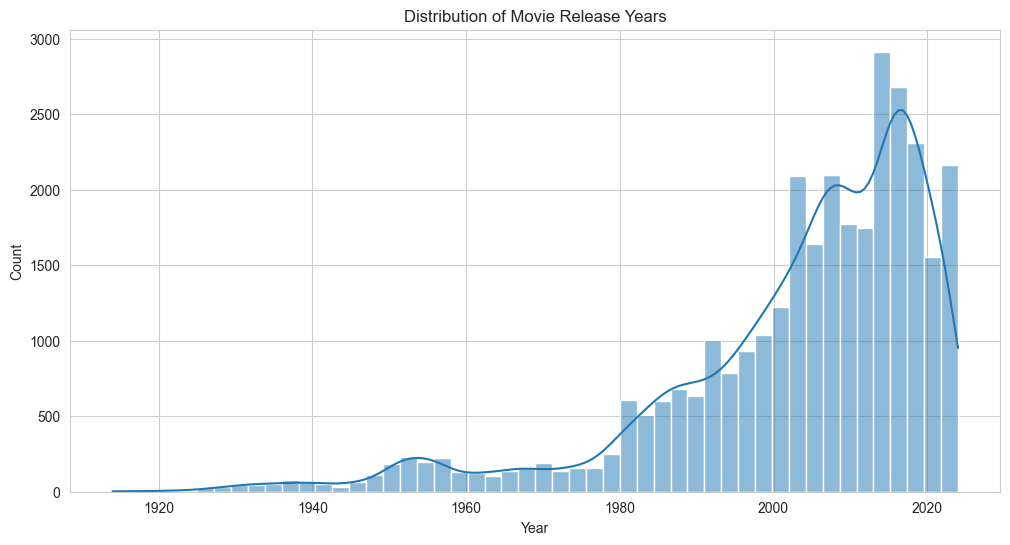

In [50]:
# Analyze distribution of movie release dates
plt.figure(figsize=(12, 6))
sns.histplot(new_merged_df["Year"].dropna(), bins=50, kde=True)
plt.title("Distribution of Movie Release Years")
plt.xlabel("Year")
plt.show()

We also plot the distribution of the worldwide box office revenue. This allow us to see how the revenue is concentrated across films and check for any potential groups dominating the market.
Note that we have not yet taken into account the global inflation (which is necessary in order to avoid any bias towards more recent films).

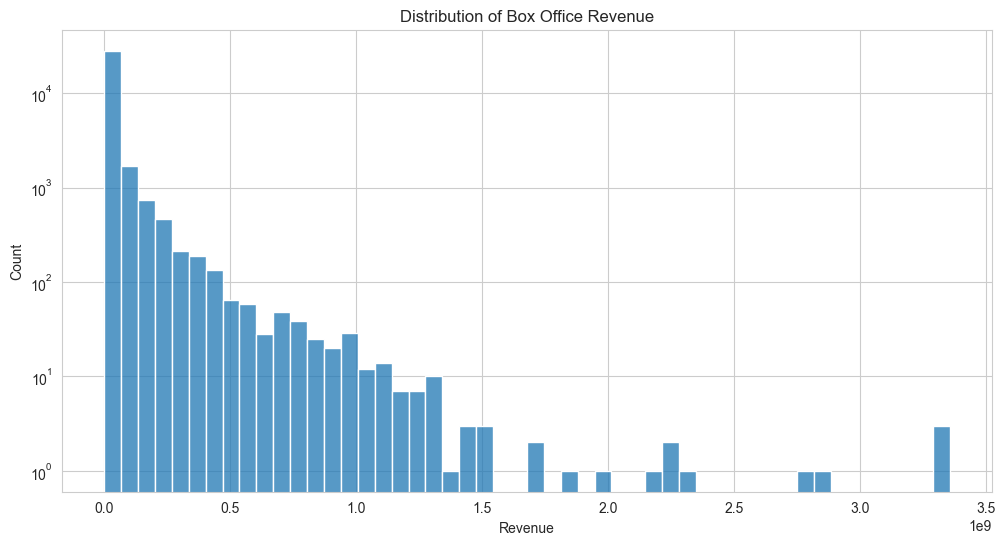

In [51]:
# Analyze distribution of box office revenue
plt.figure(figsize=(12, 6))
sns.histplot(new_merged_df["worldwide"].dropna(), bins=50)
plt.title("Distribution of Box Office Revenue")
plt.xlabel("Revenue")
plt.yscale("log")
plt.show()

Plotting the top 15 countries by number of produced movies, one can see that the US is by far the biggest producer of movies, followed by India and then UK.

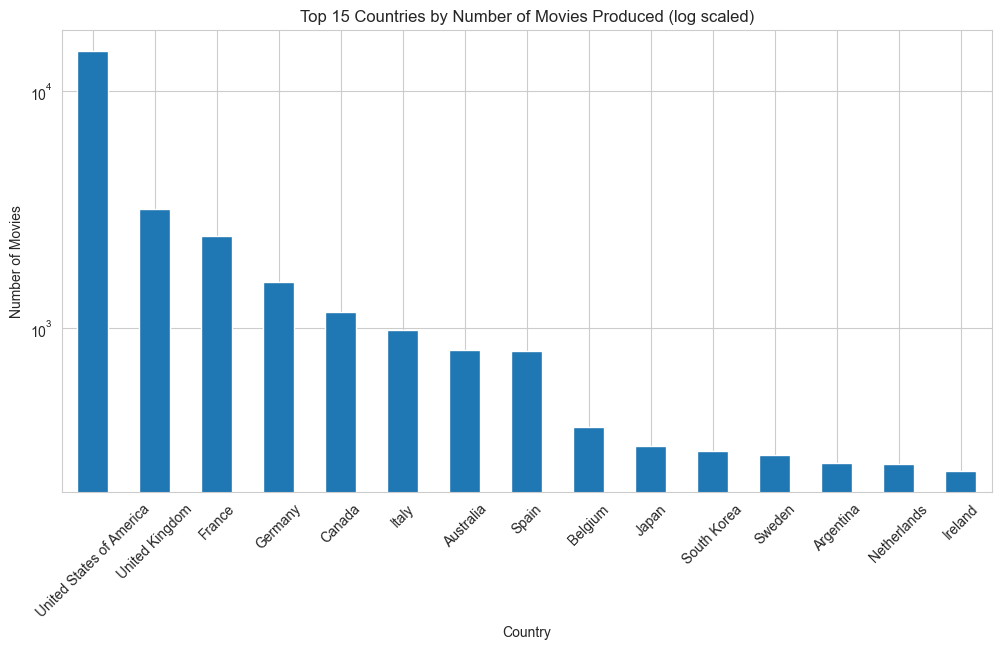

In [52]:
countries_count = new_merged_df['originLabel'].value_counts(dropna=True).head(15)

plt.figure(figsize=(12, 6))
countries_count.plot(kind='bar')
plt.title('Top 15 Countries by Number of Movies Produced (log scaled)')
plt.yscale('log')
plt.xlabel('Country')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45)
plt.show()

Using the dataset cost_of_living, we can search for the countries where the tickets prices are the highest in average (as of 2022). We see that Switzerland and Liechstenstein lead the ranking.

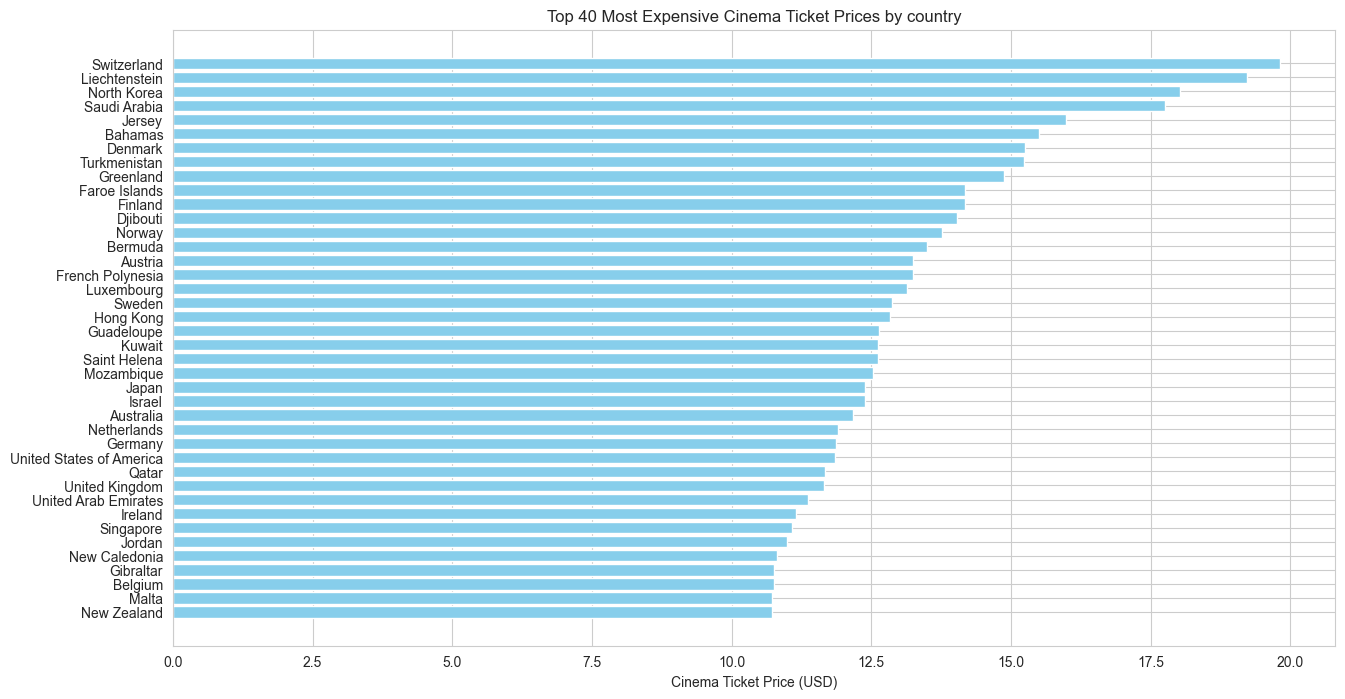

In [53]:
# getting and plotting the average cinema ticket price for the 40 most expensive countries
df_cinema = df_cost_of_living[['country', 'x41']]
df_cinema.columns = ['country', 'ticket_price']

df_cinema.loc[:, 'country'] = df_cinema['country'].apply(lambda x: str(x).replace('United States', 'United States of America'))

df_cinema.loc[:, 'ticket_price'] = pd.to_numeric(df_cinema['ticket_price'], errors='coerce')
df_cinema = df_cinema.dropna(subset=['ticket_price'])
df_cinema = df_cinema.groupby('country', as_index=False).mean()

df_top_40 = df_cinema.sort_values(by='ticket_price', ascending=False).head(40)

plt.figure(figsize=(15, 8))
plt.barh(df_top_40['country'], df_top_40['ticket_price'], color='skyblue')
plt.xlabel('Cinema Ticket Price (USD)')
plt.title('Top 40 Most Expensive Cinema Ticket Prices by country')
plt.gca().invert_yaxis()  # Invert y-axis to show the most expensive at the top
plt.show()


For the the following parts, we decided to focus on some specific countries : the top 2 to 4 countries per continent with the highest revenue (for the movie industry).

In [54]:
country_revenue = new_merged_df.groupby('originLabel')['worldwide'].sum().reset_index()
country_revenue = country_revenue.sort_values('worldwide', ascending=False)
display(country_revenue.head(50))

# We select some interesting countries
countries = ['United States of America',  'Canada', 'Germany', 'United Kingdom', 'France', 'Australia', 'New Zealand', 'Japan', 'China', 'Hong Kong', 'India', 'South Korea', 'South Africa', 'Mexico', 'Nigeria', 'Argentina']

,originLabel,worldwide
160,United States of America,6.933871e+11
159,United Kingdom,1.267761e+11
57,Germany,5.006672e+10
50,France,3.745136e+10
25,Canada,3.217457e+10
7,Australia,3.129578e+10
73,Italy,1.725462e+10
76,Japan,1.478682e+10
108,New Zealand,1.164295e+10
30,China,1.014271e+10


We perform similar analysis as before but only our selected countries.

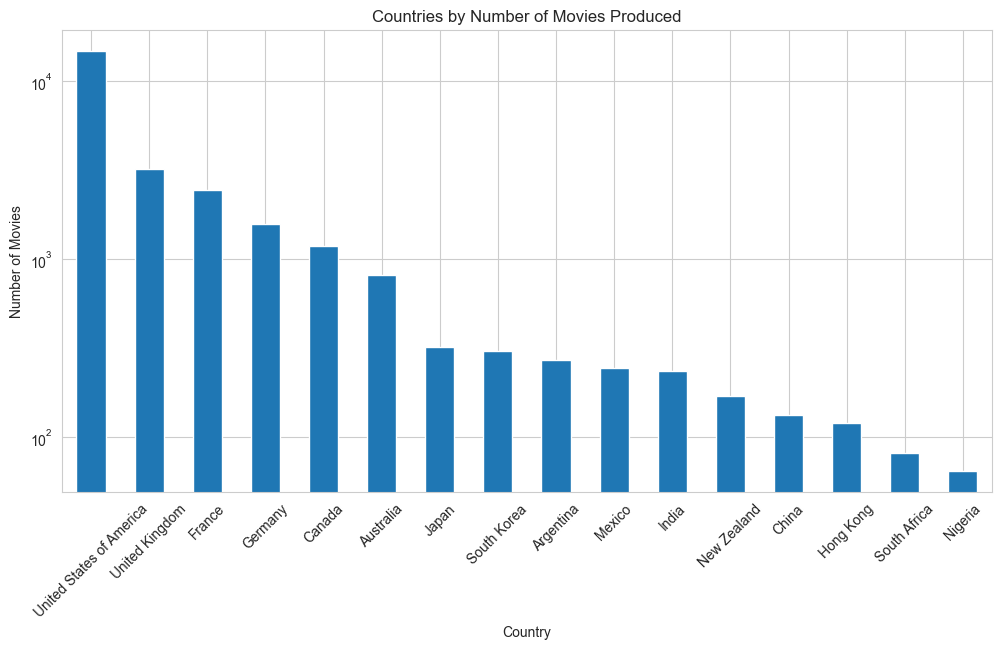

In [55]:
# We check the number of movies produced for our selected countries
new_merged_df_copy = new_merged_df[new_merged_df['originLabel'].isin(countries)]

countries_count = new_merged_df_copy['originLabel'].value_counts()

plt.figure(figsize=(12, 6))
countries_count.plot(kind='bar')
plt.title('Countries by Number of Movies Produced')
plt.yscale('log')
plt.xlabel('Country')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45)
plt.show()

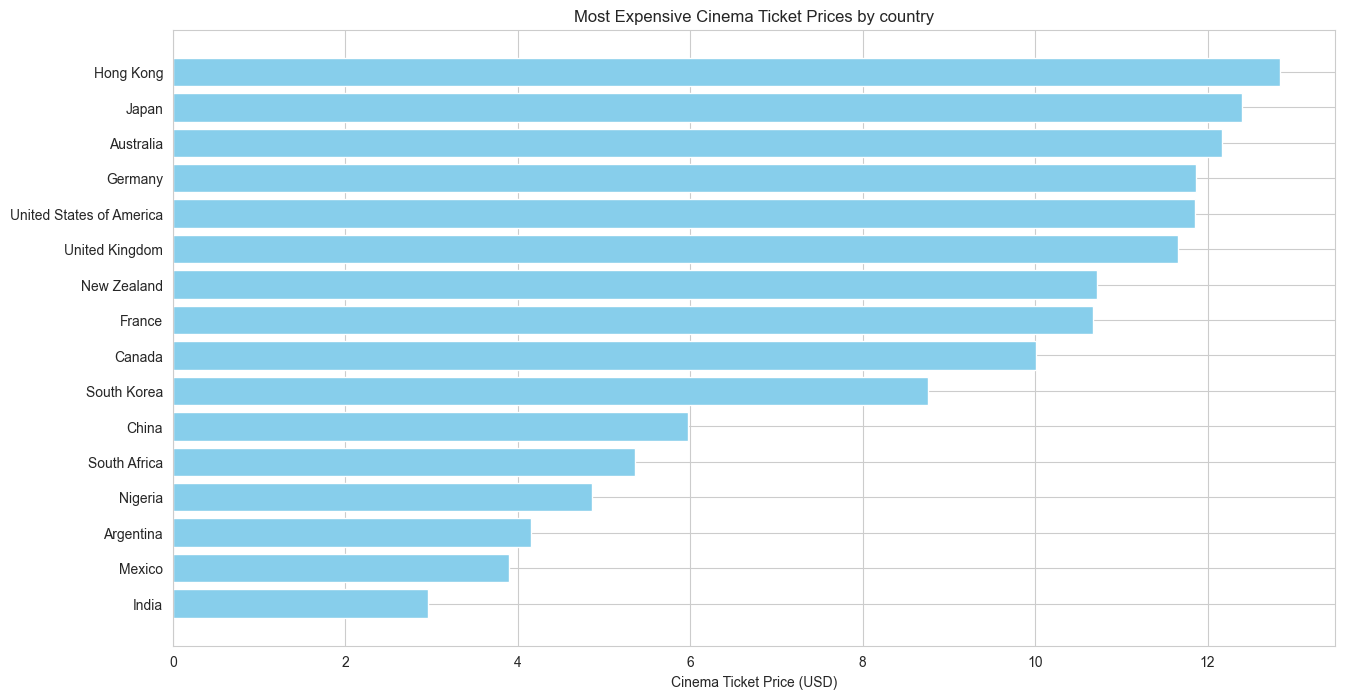

In [56]:
# Check the cinema ticket prices for our selected countries
df_cinema = df_cinema[df_cinema['country'].isin(countries)]
df_cinema = df_cinema.sort_values(by='ticket_price', ascending=False)

plt.figure(figsize=(15, 8))
plt.barh(df_cinema['country'], df_cinema['ticket_price'], color='skyblue')
plt.xlabel('Cinema Ticket Price (USD)')
plt.title('Most Expensive Cinema Ticket Prices by country')
plt.gca().invert_yaxis() 
plt.show()

We perform a boxplot on the cinema ticket price (still using stats from 2022) price distribution by country. This help us to highlight differences in ticket prices across our selected countries and will also be useful later on when determining the reasons if high revenue are caused by higher prices or higher attendances when studying on a national level.

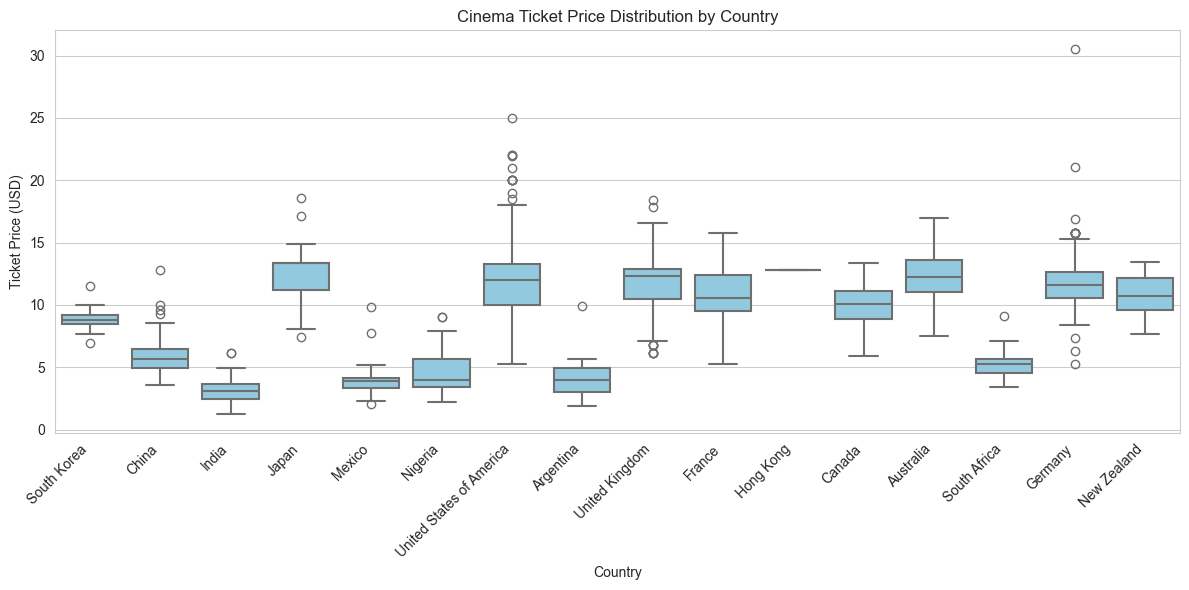

In [57]:
# Check the cinema ticket prices for our selected countries via boxplot
df_cinema = df_cost_of_living[['country', 'x41']]
df_cinema.columns = ['country', 'ticket_price']

df_cinema.loc[:, 'country'] = df_cinema['country'].apply(lambda x: str(x).replace('United States', 'United States of America'))
df_cinema = df_cinema[df_cinema['country'].isin(countries)]

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_cinema, x="country", y="ticket_price", color="skyblue", linewidth=1.5)
plt.title('Cinema Ticket Price Distribution by Country')
plt.xlabel('Country')
plt.ylabel('Ticket Price (USD)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

We plot the population of our selected countries (as of 2022) using a bar plot and a pie plot. As the previous plot, those will be useful later on since when we will normalize the selected countries movies' industry revenue by population and ticket prices.

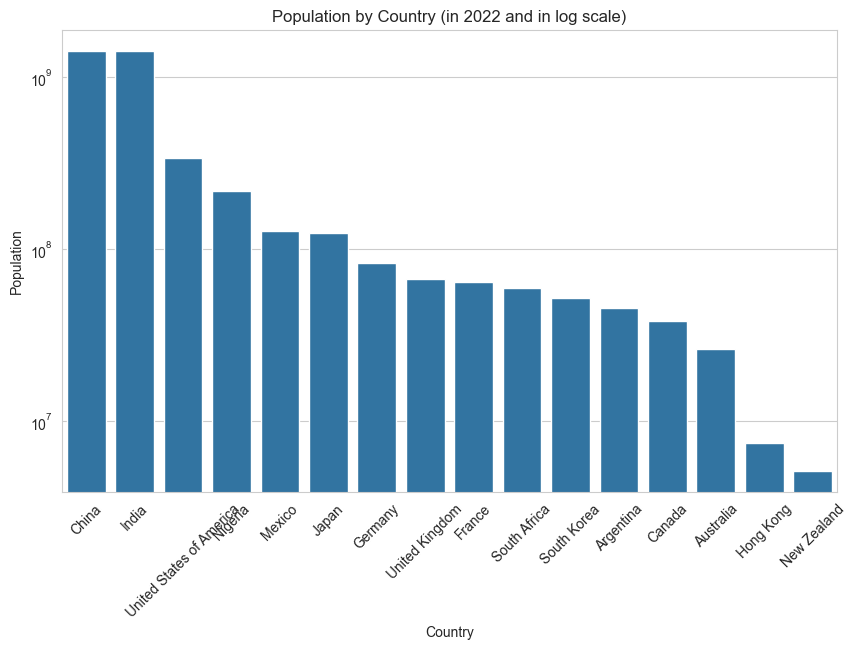

In [58]:
# Check population for our selected countries
df_preprocessed = df_world_population[["Country/Territory", "2022 Population"]]
df_preprocessed.columns = ["countries", "population"]

df_preprocessed.loc[:, 'countries'] = df_preprocessed['countries'].apply(lambda x: str(x).replace('United States', 'United States of America'))


df_countries = df_preprocessed[df_preprocessed["countries"].isin(countries)]
df_countries = df_countries.sort_values(by="population", ascending=False)

sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(x="countries", y="population", data=df_countries, dodge=False, legend=False)
plt.title("Population by Country (in 2022 and in log scale)")
plt.yscale("log")
plt.xlabel("Country")
plt.ylabel("Population")
plt.xticks(rotation=45)
plt.show()